# Capstone Project - Alcohal Outlet and Crime Rate Relationship
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: <a name="introduction"></a>

**Alcohol** abuse can increase the likelihood that individuals will commit certain crimes such as assault or homicide either by reducing their inhibitions or judgment or by increasing their agitation and anger. Finally, being the victim of certain types of crimes such as child or sexual abuse makes it considerably more likely that some individuals will develop alcohol abuse disorders later in life.


This is project is done to find the most habitual place and neighborhood for work or leaving in **San Francisco**, by finding the direct relationship between **alcohol outlet Crime rate per neighborhood**.


### Importing Libraries

In [114]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium

##### Geting San Francisco Coordiantes

In [115]:
def do_geocode(address):
    geopy = Nominatim()
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

address = 'San Francisco'
do_geocode(address)


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco City are {}, {}.'.format(latitude, longitude))

c:\users\sabertooth tech\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of San Francisco City are 37.7792808, -122.4192363.


##### Loading Data

In [116]:
crime_data = pd.read_csv('Crime Data.csv')

In [117]:
crime_data = crime_data.head(500)

In [118]:
crime_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


##### Plotting Crime Data on Folium

In [113]:
from folium import plugins

sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles="OpenStreetMap")

incidents = plugins.MarkerCluster().add_to(sanfran_map)
# add markers to map
for lat, lng, borough, neighborhood in zip(crime_data['Y'], crime_data['X'], crime_data['Descript'], crime_data['PdDistrict']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(incidents)   

sanfran_map

##### Scraping data from wikipedia

In [11]:
from bs4 import BeautifulSoup

import urllib.request as urb
import requests
import pandas as pd

link = "https://en.wikipedia.org/wiki/Category:Neighborhoods_in_San_Francisco"
html = urb.urlopen(link)
soup = BeautifulSoup(html, "lxml")

html_table = soup.select(".mw-category .mw-category-group ul li")
addresses = [i.get_text()  for i in html_table][20:]

In [12]:
from tqdm import tqdm

In [13]:
latitudes = []
longitudes =[]
neighboor =[]
for address in tqdm(addresses):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        neighboor.append(address)
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [02:11<00:00,  1.27s/it]


In [14]:
neighborhoods = pd.DataFrame({
    'Neighborhood':neighboor,
    'Latitude':latitudes,
    'Longitude':longitudes
})

In [15]:
CLIENT_ID = 'XWRASQP1I4DQ01QCJGOITYJWVFKRJU1JYIV2REQX20Y4CLRL' # your Foursquare ID
CLIENT_SECRET = '4ZBR0QCYMG4OJDIXBM025FVS2F0UO3BZXT31BZB4DBDOLBRI' # your Foursquare Secret
VERSION = '20180604'

##### Getting venues in San Francisco using Foursquare API

In [16]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d39bfd5e168810025c36d56'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Civic Center',
  'headerFullLocation': 'Civic Center, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 124,
  'suggestedBounds': {'ne': {'lat': 37.783780804500005,
    'lng': -122.41355343630961},
   'sw': {'lat': 37.7747807955, 'lng': -122.42491916369038}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4aa48566f964a520024720e3',
       'name': 'Louise M. Davies Symphony Hall',
       'location': {'address': '201 Van Ness Ave',
        'crossStreet': 'btwn Grove & Hayes St',
        'lat': 37.77797

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Louise M. Davies Symphony Hall,Concert Hall,37.777976,-122.420157
1,Herbst Theater,Concert Hall,37.779548,-122.420953
2,War Memorial Opera House,Opera House,37.778601,-122.420816
3,San Francisco Ballet,Dance Studio,37.778580,-122.420798
4,War Memorial Court,Park,37.779042,-122.420971


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
san_francisco_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Crocker-Amazon, San Francisco
Dogpatch, San Francisco
Duboce Triangle, San Francisco
Eureka Valley, San Francisco
Fillmore District, San Francisco
Financial District, San Francisco
Fisherman's Wharf, San Francisco
Forest Hill, San Francisco
Forest Knolls, San Francisco
Glen Park, San Francisco
Haight-Ashbury
Hayes Valley, San Francisco
Hunters Point, San Francisco, California
India Basin, San Francisco
Ingleside, San Francisco, California
Inner Sunset
Irish Hill (San Francisco)
Jackson Square, San Francisco
Japantown, San Francisco
Laurel Heights, San Francisco
Lincoln Manor
Lone Mountain (California)
Lower Haight, San Francisco
Lower Pacific Heights, San Francisco
Marina District, San Francisco
Merced Manor, San Francisco
Mission Bay, San Francisco
Mission District, San Francisco
Mount Davidson (California)
Nob Hill, San Francisco
Noe Valley, San Francisco
North Beach, San Francisco
Oceanview, San Francisco
Outer Mission, San Francisco
Outer Sunset, San Francisco, California
Pacific H

In [23]:
san_francisco_venues['Venue Category'].value_counts()

Coffee Shop                                 101
Café                                         77
Pizza Place                                  70
Italian Restaurant                           65
Park                                         58
Bakery                                       52
Gym / Fitness Center                         51
Sandwich Place                               49
Gym                                          48
Chinese Restaurant                           47
Wine Bar                                     46
Mexican Restaurant                           42
Grocery Store                                42
Sushi Restaurant                             42
Cocktail Bar                                 39
Ice Cream Shop                               38
Bar                                          36
New American Restaurant                      35
Boutique                                     33
American Restaurant                          32
Cosmetics Shop                          

##### Filter out venues which comes in alcohol Categories

In [24]:
searchfor = ['Bar','Liquor','Beer','Whiskey','Pub','Wine']
Bar_Venues = san_francisco_venues[san_francisco_venues['Venue Category'].str.contains('|'.join(searchfor))]
Bar_Venues['Neighborhood'] = [i[0] for i in Bar_Venues.Neighborhood.str.split(',')]
Bar_Venues.head()

c:\users\sabertooth tech\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crocker-Amazon,37.709378,-122.438587,Cordova Market,37.713503,-122.436389,Liquor Store
5,Dogpatch,37.760698,-122.389202,Third Rail,37.760562,-122.388264,Cocktail Bar
6,Dogpatch,37.760698,-122.389202,Sea Star,37.760678,-122.388464,Bar
12,Dogpatch,37.760698,-122.389202,Ungrafted,37.759008,-122.388262,Wine Bar
19,Dogpatch,37.760698,-122.389202,Dogpatch Saloon,37.757963,-122.388534,Cocktail Bar


In [25]:
Bar_Venues.shape

(260, 7)

##### Superimposed Crime Data on Venue

In [26]:
from IPython.display import Image

sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=10)

incidents = plugins.MarkerCluster().add_to(sanfran_map)
# add markers to map
for lat, lng, borough, neighborhood in zip(Bar_Venues['Venue Latitude'], Bar_Venues['Venue Longitude'], Bar_Venues['Venue'], Bar_Venues['Venue Category']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(incidents)
incidents = plugins.MarkerCluster().add_to(sanfran_map)
# add markers to map
for lat, lng, borough, neighborhood in zip(crime_data['Y'], crime_data['X'], crime_data['Descript'], crime_data['PdDistrict']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sanfran_map) 

sanfran_map

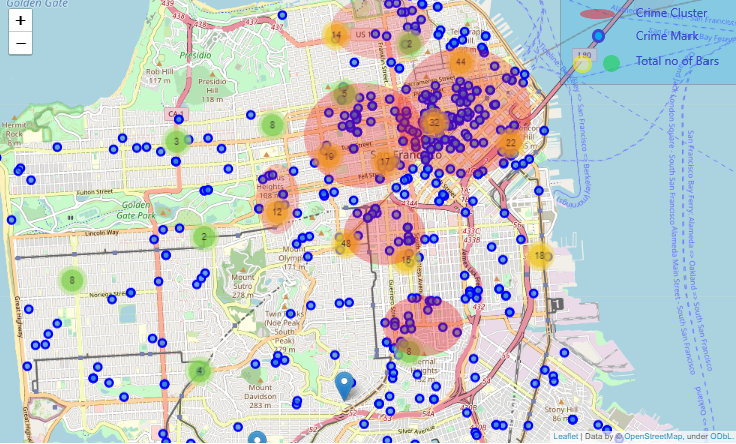

In [27]:
Image("Crime_Bar_Relationship_Map.png")

In [97]:
sf_crime_data = pd.read_csv('SF Crime Data Liquor.csv')

sf_crime_data.head()

,incident_date,incident_datetime,analysis_neighborhood,incident_category,incident_category.1,resolution,police_district,incident_description,incident_number
0,2019-07-10T00:00:00.000,2019-07-10T13:41:00.000,Bayview Hunters Point,Drug Violation,Drug Violation,Cite or Arrest Adult,Bayview,"Firearm, Armed While Possessing Controlled Sub...",190499145
1,2019-07-08T00:00:00.000,2019-07-08T20:44:00.000,Tenderloin,Drug Violation,Drug Violation,Cite or Arrest Adult,Tenderloin,"Firearm, Armed While Possessing Controlled Sub...",190494991
2,2019-07-04T00:00:00.000,2019-07-04T19:09:00.000,West of Twin Peaks,Liquor Laws,Liquor Laws,Open or Active,Taraval,"Alcohol, Possession Of By Minor",190484801
3,2019-07-02T00:00:00.000,2019-07-02T16:35:00.000,Mission,Drug Violation,Drug Violation,Cite or Arrest Adult,Mission,"Firearm, Armed While Possessing Controlled Sub...",190479175
4,2019-07-02T00:00:00.000,2019-07-02T16:37:00.000,Mission,Drug Violation,Drug Violation,Cite or Arrest Adult,Mission,"Firearm, Armed While Possessing Controlled Sub...",190479175


In [98]:
Bar_counts = Bar_Venues.groupby('Neighborhood').count().reset_index()[['Neighborhood','Venue']]
Bar_counts.columns = ['Neighborhood','Total No of Bars']
Bar_counts.head()

,Neighborhood,Total No of Bars
0,Crocker-Amazon,1
1,Dogpatch,8
2,Duboce Triangle,10
3,Eureka Valley,16
4,Fillmore District,4


In [99]:
sf_crime_count = sf_crime_data.groupby('analysis_neighborhood').count().reset_index()[['analysis_neighborhood','resolution']]
sf_crime_count.columns = ['Neighborhood','Total No of Crimes']
sf_crime_count.head()

,Neighborhood,Total No of Crimes
0,Bayview Hunters Point,4
1,Castro/Upper Market,1
2,Haight Ashbury,2
3,Hayes Valley,3
4,Japantown,1


##### Merge Data 

In [100]:
mdf = pd.merge(Bar_counts, sf_crime_count, on = 'Neighborhood')

In [101]:
mdf = mdf.sort_values('Total No of Bars',ascending = False)

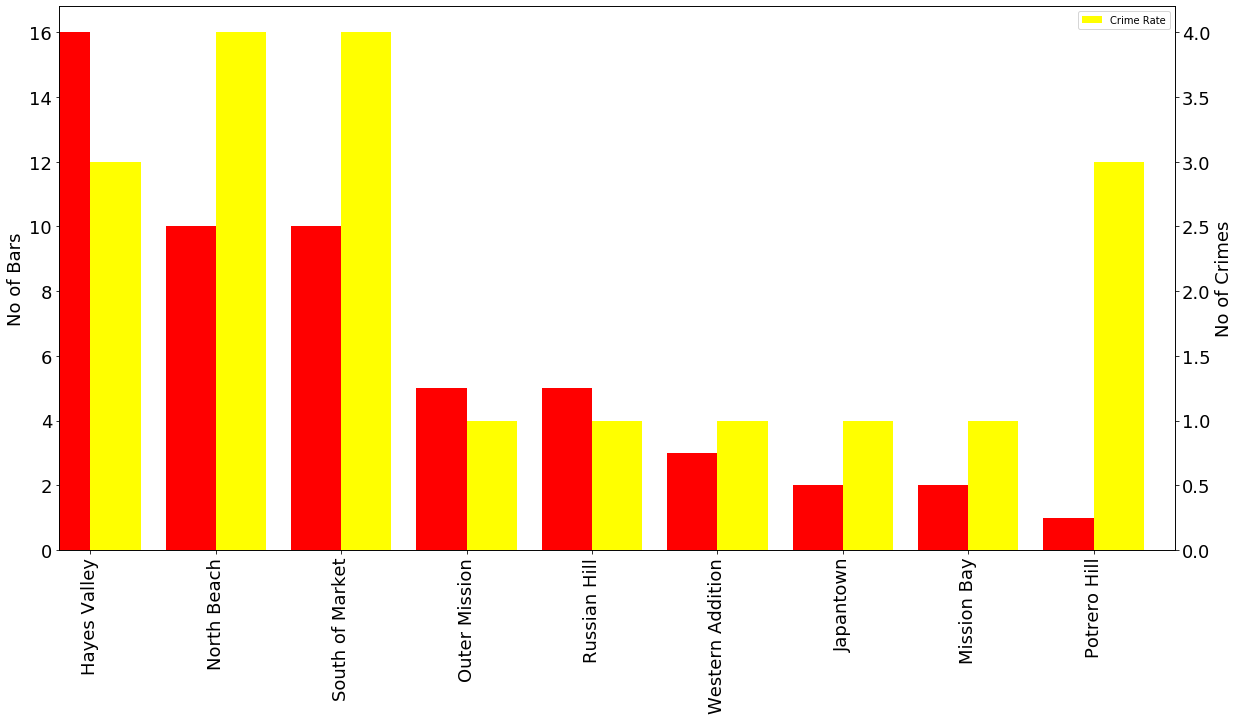

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

x = [i for i in range(len(mdf['Neighborhood']))]
width = 0.4

mdf['Total No of Bars'].plot(kind='bar', color='red', ax=ax, width=width, position=1, fontsize=18)
mdf['Total No of Crimes'].plot(kind='bar', color='yellow', ax=ax2, width=width, position=0 , fontsize=18)

ax.set_ylabel('No of Bars', fontsize=18)
ax2.set_ylabel('No of Crimes', fontsize=18)

plt.legend(["Crime Rate"])

plt.xticks(x, mdf['Neighborhood'], rotation='vertical', fontsize=18)
plt.show()

### Analyze Each Neighborhood

In [35]:
sf_crime_data_onehot = pd.get_dummies(sf_crime_data[['incident_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_crime_data_onehot['analysis_neighborhood'] = sf_crime_data['analysis_neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_crime_data_onehot.columns[-1]] + list(sf_crime_data_onehot.columns[:-1])
sf_crime_data_onehot = sf_crime_data_onehot[fixed_columns]

sf_crime_data_onehot.head()

,analysis_neighborhood,Arson,Assault,Burglary,Case Closure,Civil Sidewalks,Courtesy Report,Disorderly Conduct,Drug Offense,Drug Violation,Embezzlement,Family Offense,Fire Report,Forgery And Counterfeiting,Fraud,Homicide,Juvenile Offenses,Larceny Theft,Liquor Laws,Lost Property,Malicious Mischief,Miscellaneous Investigation,Missing Person,Motor Vehicle Theft,Motor Vehicle Theft?,Non-Criminal,Offences Against The Family And Children,Other,Other Miscellaneous,Other Offenses,Prostitution,Rape,Recovered Vehicle,Robbery,Sex Offense,Stolen Property,Suicide,Suspicious Occ,Traffic Collision,Traffic Violation Arrest,Vandalism,Vehicle Impounded,Vehicle Misplaced,Warrant,Weapons Carrying Etc,Weapons Offence,Weapons Offense
0,Nob Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Golden Gate Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Golden Gate Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Financial District/South Beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Financial District/South Beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####  Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [36]:
sf_crime_data_grouped = sf_crime_data_onehot.groupby('analysis_neighborhood').mean().reset_index()
sf_crime_data_grouped

,analysis_neighborhood,Arson,Assault,Burglary,Case Closure,Civil Sidewalks,Courtesy Report,Disorderly Conduct,Drug Offense,Drug Violation,Embezzlement,Family Offense,Fire Report,Forgery And Counterfeiting,Fraud,Homicide,Juvenile Offenses,Larceny Theft,Liquor Laws,Lost Property,Malicious Mischief,Miscellaneous Investigation,Missing Person,Motor Vehicle Theft,Motor Vehicle Theft?,Non-Criminal,Offences Against The Family And Children,Other,Other Miscellaneous,Other Offenses,Prostitution,Rape,Recovered Vehicle,Robbery,Sex Offense,Stolen Property,Suicide,Suspicious Occ,Traffic Collision,Traffic Violation Arrest,Vandalism,Vehicle Impounded,Vehicle Misplaced,Warrant,Weapons Carrying Etc,Weapons Offence,Weapons Offense
0,Bayview Hunters Point,0.076923,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.00000,0.000000,0.269231,0.000000,0.000000,0.038462,0.000000,0.038462,0.076923,0.038462,0.076923,0.000000,0.000000,0.00000,0.076923,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000
1,Bernal Heights,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.00000,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.142857,0.142857,0.000000,0.214286,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Castro/Upper Market,0.000000,0.091667,0.055556,0.016667,0.008333,0.000000,0.016667,0.033333,0.000000,0.002778,0.000000,0.000000,0.008333,0.027778,0.000000,0.000000,0.247222,0.00000,0.047222,0.050000,0.008333,0.013889,0.025000,0.000000,0.088889,0.005556,0.011111,0.077778,0.011111,0.000000,0.00000,0.019444,0.019444,0.000000,0.002778,0.002778,0.011111,0.002778,0.019444,0.005556,0.000000,0.000000,0.063889,0.000000,0.000000,0.005556
3,Chinatown,0.008130,0.060976,0.024390,0.000000,0.000000,0.044715,0.004065,0.004065,0.000000,0.000000,0.004065,0.000000,0.004065,0.028455,0.000000,0.000000,0.349593,0.00000,0.069106,0.085366,0.012195,0.024390,0.024390,0.000000,0.113821,0.012195,0.000000,0.012195,0.004065,0.000000,0.00000,0.004065,0.008130,0.004065,0.004065,0.000000,0.028455,0.000000,0.012195,0.000000,0.000000,0.000000,0.044715,0.000000,0.000000,0.004065
4,Financial District/South Beach,0.003240,0.087473,0.052916,0.000000,0.000000,0.001080,0.017279,0.009719,0.000000,0.000000,0.002160,0.000000,0.009719,0.023758,0.001080,0.000000,0.396328,0.00000,0.051836,0.056156,0.002160,0.014039,0.014039,0.000000,0.046436,0.009719,0.003240,0.093952,0.002160,0.000000,0.00000,0.007559,0.026998,0.000000,0.003240,0.000000,0.008639,0.002160,0.009719,0.000000,0.000000,0.000000,0.037797,0.002160,0.000000,0.003240
5,Golden Gate Park,0.000000,0.053097,0.044248,0.000000,0.000000,0.008850,0.008850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026549,0.000000,0.000000,0.371681,0.00000,0.035398,0.061947,0.008850,0.061947,0.017699,0.000000,0.053097,0.000000,0.008850,0.061947,0.000000,0.000000,0.00000,0.061947,0.026549,0.008850,0.008850,0.000000,0.000000,0.000000,0.017699,0.000000,0.008850,0.000000,0.035398,0.008850,0.000000,0.000000
6,Haight Ashbury,0.000000,0.048485,0.030303,0.024242,0.072727,0.000000,0.006061,0.042424,0.000000,0.000000,0.000000,0.000000,0.012121,0.036364,0.000000,0.006061,0.290909,0.00000,0.030303,0.048485,0.018182,0.048485,0.018182,0.000000,0.060606,0.006061,0.000000,0.042424,0.024242,0.000000,0.00000,0.012121,0.006061,0.000000,0.000000,0.000000,0.024242,0.000000,0.012121,0.006061,0.000000,0.000000,0.072727,0.000000,0.000000,0.000000
7,Hayes Valley,0.006250,0.065625,0.053125,0.009375,0.003125,0.000000,0.018750,0.006250,0.000000,0.000000,0.000000,0.000000,0.000000,0.028125,0.000000,0.000000,0.434375,0.00000,0.031250,0.071875,0.000000,0.021875,0.025000,0.000000,0.046875,0.018750,0.0

In [37]:
sf_crime_data_grouped.shape

(30, 47)

#### Print each neighborhood along with the top 5 most common crime

In [38]:
num_top_crimes = 5

for hood in sf_crime_data_grouped['analysis_neighborhood']:
    print("----"+hood+"----")
    temp = sf_crime_data_grouped[sf_crime_data_grouped['analysis_neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_crimes))
    print('\n')

----Bayview Hunters Point----
                 venue  freq
0   Malicious Mischief  0.27
1        Larceny Theft  0.15
2                Arson  0.08
3  Other Miscellaneous  0.08
4    Recovered Vehicle  0.08


----Bernal Heights----
                                      venue  freq
0                       Other Miscellaneous  0.21
1  Offences Against The Family And Children  0.14
2                              Non-Criminal  0.14
3                  Traffic Violation Arrest  0.14
4                                   Assault  0.07


----Castro/Upper Market----
                 venue  freq
0        Larceny Theft  0.25
1         Non-Criminal  0.09
2              Assault  0.09
3  Other Miscellaneous  0.08
4             Burglary  0.06


----Chinatown----
                venue  freq
0       Larceny Theft  0.35
1        Non-Criminal  0.11
2  Malicious Mischief  0.09
3       Lost Property  0.07
4             Assault  0.06


----Financial District/South Beach----
                 venue  freq
0        

In [39]:
def return_most_common_crimes(row, num_top_crimes):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_crimes]

num_top_crimes = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top crimes
columns = ['analysis_neighborhood']
for ind in np.arange(num_top_crimes):
    try:
        columns.append('{}{} Most Common Crime'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Crime'.format(ind+1))

# create a new dataframe
analysis_neighborhoods_crimes_sorted = pd.DataFrame(columns=columns)
analysis_neighborhoods_crimes_sorted['analysis_neighborhood'] = sf_crime_data_grouped['analysis_neighborhood']

for ind in np.arange(sf_crime_data_grouped.shape[0]):
    analysis_neighborhoods_crimes_sorted.iloc[ind, 1:] = return_most_common_crimes(sf_crime_data_grouped.iloc[ind, :], num_top_crimes)

analysis_neighborhoods_crimes_sorted.head()

,analysis_neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
0,Bayview Hunters Point,Malicious Mischief,Larceny Theft,Arson,Warrant,Offences Against The Family And Children,Other Miscellaneous,Recovered Vehicle,Stolen Property,Burglary,Non-Criminal
1,Bernal Heights,Other Miscellaneous,Non-Criminal,Offences Against The Family And Children,Traffic Violation Arrest,Motor Vehicle Theft,Assault,Larceny Theft,Suspicious Occ,Malicious Mischief,Forgery And Counterfeiting
2,Castro/Upper Market,Larceny Theft,Assault,Non-Criminal,Other Miscellaneous,Warrant,Burglary,Malicious Mischief,Lost Property,Drug Offense,Fraud
3,Chinatown,Larceny Theft,Non-Criminal,Malicious Mischief,Lost Property,Assault,Warrant,Courtesy Report,Fraud,Suspicious Occ,Motor Vehicle Theft
4,Financial District/South Beach,Larceny Theft,Other Miscellaneous,Assault,Malicious Mischief,Burglary,Lost Property,Non-Criminal,Warrant,Robbery,Fraud


### Run K-means to cluster the neighborhood into 5 clusters.

In [40]:
kclusters = 5

sf_crime_data_grouped_clustering = sf_crime_data_grouped.drop('analysis_neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_crime_data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([1, 4, 3, 0, 0, 0, 3, 0, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 2, 3, 0, 0,
       0, 2, 3, 3, 3, 0, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [54]:
analysis_neighborhoods_crimes_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [43]:
neighborhoods.columns = ['analysis_neighborhood','Latitude','Longitude']

In [44]:
analysis_neighborhoods_crimes_sorted['analysis_neighborhood'] = [i[0] + ', San Francisco' for i in analysis_neighborhoods_crimes_sorted.analysis_neighborhood.str.split('/')]

In [45]:
latitudes = []
longitudes =[]
neighboor =[]
for address in tqdm(analysis_neighborhoods_crimes_sorted['analysis_neighborhood']):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        neighboor.append(address)
    except:
        print(address)
        pass

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Bayview Hunters Point, San Francisco


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:25<00:12,  1.29s/it]

Pacific Heights, San Francisco


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:35<00:02,  1.07s/it]

West of Twin Peaks, San Francisco


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.03it/s]


In [49]:
latitudes.append('40.632337	')
longitudes.append('-111.873880')

In [50]:
analysis_neighborhoods_crimes_sorted['Latitude'] = latitudes
analysis_neighborhoods_crimes_sorted['Longitude'] = longitudes

In [51]:
analysis_neighborhoods_crimes_sorted

,analysis_neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Latitude,Longitude
0,"Bayview Hunters Point, San Francisco",Malicious Mischief,Larceny Theft,Arson,Warrant,Offences Against The Family And Children,Other Miscellaneous,Recovered Vehicle,Stolen Property,Burglary,Non-Criminal,37.741,-122.414
1,"Bernal Heights, San Francisco",Other Miscellaneous,Non-Criminal,Offences Against The Family And Children,Traffic Violation Arrest,Motor Vehicle Theft,Assault,Larceny Theft,Suspicious Occ,Malicious Mischief,Forgery And Counterfeiting,9.69041,-84.1138
2,"Castro, San Francisco",Larceny Theft,Assault,Non-Criminal,Other Miscellaneous,Warrant,Burglary,Malicious Mischief,Lost Property,Drug Offense,Fraud,52.3752,4.90094
3,"Chinatown, San Francisco",Larceny Theft,Non-Criminal,Malicious Mischief,Lost Property,Assault,Warrant,Courtesy Report,Fraud,Suspicious Occ,Motor Vehicle Theft,37.7936,-122.399
4,"Financial District, San Francisco",Larceny Theft,Other Miscellaneous,Assault,Malicious Mischief,Burglary,Lost Property,Non-Criminal,Warrant,Robbery,Fraud,37.7694,-122.482
5,"Golden Gate Park, San Francisco",Larceny Theft,Malicious Mischief,Missing Person,Other Miscellaneous,Recovered Vehicle,Assault,Non-Criminal,Burglary,Warrant,Lost Property,37.77,-122.447
6,"Haight Ashbury, San Francisco",Larceny Theft,Warrant,Civil Sidewalks,Non-Criminal,Missing Person,Assault,Malicious Mischief,Other Miscellaneous,Drug Offense,Fraud,37.7767,-122.423
7,"Hayes Valley, San Francisco",Larceny Theft,Malicious Mischief,Assault,Other Miscellaneous,Burglary,Non-Criminal,Lost Property,Fraud,Robbery,Motor Vehicle Theft,37.7703,-122.47
8,"Inner Richmond, San Francisco",Larceny Theft,Non-Criminal,Malicious Mischief,Assault,Motor Vehicle Theft,Recovered Vehicle,Suspicious Occ,Fraud,Other Miscellaneous,Lost Property,37.7615,-122.468
9,"Inner Sunset, San Francisco",Larceny Theft,Fraud,Burglary,Missing Person,Motor Vehicle Theft,Malicious Mischief,Non-Criminal,Suspicious Occ,Other Miscellaneous,Warrant,37.7856,-122.43


In [55]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(analysis_neighborhoods_crimes_sorted['Latitude'], analysis_neighborhoods_crimes_sorted['Longitude'], analysis_neighborhoods_crimes_sorted['analysis_neighborhood'], analysis_neighborhoods_crimes_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Cluster 

#### Cluster 1

In [121]:
analysis_neighborhoods_crimes_sorted.loc[analysis_neighborhoods_crimes_sorted['Cluster Labels'] == 0, analysis_neighborhoods_crimes_sorted.columns[[1] + list(range(2, analysis_neighborhoods_crimes_sorted.shape[1]))]]

,analysis_neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Latitude,Longitude
3,"Chinatown, San Francisco",Larceny Theft,Non-Criminal,Malicious Mischief,Lost Property,Assault,Warrant,Courtesy Report,Fraud,Suspicious Occ,Motor Vehicle Theft,37.7936,-122.399
4,"Financial District, San Francisco",Larceny Theft,Other Miscellaneous,Assault,Malicious Mischief,Burglary,Lost Property,Non-Criminal,Warrant,Robbery,Fraud,37.7694,-122.482
5,"Golden Gate Park, San Francisco",Larceny Theft,Malicious Mischief,Missing Person,Other Miscellaneous,Recovered Vehicle,Assault,Non-Criminal,Burglary,Warrant,Lost Property,37.77,-122.447
7,"Hayes Valley, San Francisco",Larceny Theft,Malicious Mischief,Assault,Other Miscellaneous,Burglary,Non-Criminal,Lost Property,Fraud,Robbery,Motor Vehicle Theft,37.7703,-122.47
8,"Inner Richmond, San Francisco",Larceny Theft,Non-Criminal,Malicious Mischief,Assault,Motor Vehicle Theft,Recovered Vehicle,Suspicious Occ,Fraud,Other Miscellaneous,Lost Property,37.7615,-122.468
12,"Lone Mountain, San Francisco",Larceny Theft,Missing Person,Non-Criminal,Other Miscellaneous,Disorderly Conduct,Motor Vehicle Theft,Burglary,Warrant,Recovered Vehicle,Assault,-35.6955,-71.4078
13,"Marina, San Francisco",Larceny Theft,Burglary,Non-Criminal,Malicious Mischief,Other Miscellaneous,Motor Vehicle Theft,Disorderly Conduct,Fraud,Recovered Vehicle,Assault,37.7525,-122.413
16,"Nob Hill, San Francisco",Larceny Theft,Assault,Other Miscellaneous,Malicious Mischief,Burglary,Robbery,Non-Criminal,Drug Offense,Motor Vehicle Theft,Disorderly Conduct,37.7516,-122.432
17,"Noe Valley, San Francisco",Larceny Theft,Non-Criminal,Other,Fraud,Motor Vehicle Theft,Malicious Mischief,Burglary,Suspicious Occ,Other Miscellaneous,Recovered Vehicle,37.8012,-122.409
20,"Pacific Heights, San Francisco",Larceny Theft,Burglary,Malicious Mischief,Non-Criminal,Other Miscellaneous,Assault,Lost Property,Fraud,Suspicious Occ,Motor Vehicle Theft,37.7888,-122.453


In [122]:
analysis_neighborhoods_crimes_sorted.loc[analysis_neighborhoods_crimes_sorted['Cluster Labels'] == 2, analysis_neighborhoods_crimes_sorted.columns[[1] + list(range(3, analysis_neighborhoods_crimes_sorted.shape[1]))]]

,analysis_neighborhood,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Latitude,Longitude
10,"Japantown, San Francisco",Other Miscellaneous,Malicious Mischief,Assault,Robbery,Non-Criminal,Motor Vehicle Theft,Drug Offense,Lost Property,Traffic Violation Arrest,37.7847,-122.499
11,"Lincoln Park, San Francisco",Other Miscellaneous,Malicious Mischief,Weapons Offense,Fire Report,Lost Property,Liquor Laws,Juvenile Offenses,Homicide,Fraud,37.7791,-122.452
18,"North Beach, San Francisco",Malicious Mischief,Assault,Non-Criminal,Motor Vehicle Theft,Disorderly Conduct,Offences Against The Family And Children,Robbery,Suspicious Occ,Other Miscellaneous,37.7806,-122.473
23,"Russian Hill, San Francisco",Malicious Mischief,Other Miscellaneous,Non-Criminal,Assault,Motor Vehicle Theft,Burglary,Robbery,Recovered Vehicle,Fraud,37.7609,-122.496


In [123]:
analysis_neighborhoods_crimes_sorted.loc[analysis_neighborhoods_crimes_sorted['Cluster Labels'] == 3, analysis_neighborhoods_crimes_sorted.columns[[1] + list(range(3, analysis_neighborhoods_crimes_sorted.shape[1]))]]

,analysis_neighborhood,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Latitude,Longitude
2,"Castro, San Francisco",Assault,Non-Criminal,Other Miscellaneous,Warrant,Burglary,Malicious Mischief,Lost Property,Drug Offense,Fraud,52.3752,4.90094
6,"Haight Ashbury, San Francisco",Warrant,Civil Sidewalks,Non-Criminal,Missing Person,Assault,Malicious Mischief,Other Miscellaneous,Drug Offense,Fraud,37.7767,-122.423
9,"Inner Sunset, San Francisco",Fraud,Burglary,Missing Person,Motor Vehicle Theft,Malicious Mischief,Non-Criminal,Suspicious Occ,Other Miscellaneous,Warrant,37.7856,-122.43
14,"Mission, San Francisco",Other Miscellaneous,Assault,Non-Criminal,Warrant,Malicious Mischief,Drug Offense,Motor Vehicle Theft,Offences Against The Family And Children,Robbery,37.7708,-122.391
15,"Mission Bay, San Francisco",Malicious Mischief,Non-Criminal,Assault,Other Miscellaneous,Offences Against The Family And Children,Warrant,Burglary,Lost Property,Suspicious Occ,37.7933,-122.415
19,"Outer Richmond, San Francisco",Malicious Mischief,Other Miscellaneous,Burglary,Fraud,Non-Criminal,Assault,Warrant,Disorderly Conduct,Motor Vehicle Theft,37.7566,-122.399
24,"South of Market, San Francisco",Other Miscellaneous,Non-Criminal,Assault,Warrant,Malicious Mischief,Drug Offense,Lost Property,Motor Vehicle Theft,Missing Person,37.7842,-122.414
25,"Sunset, San Francisco",Fraud,Non-Criminal,Other Miscellaneous,Malicious Mischief,Burglary,Motor Vehicle Theft,Assault,Missing Person,Robbery,37.7546,-122.446
26,"Tenderloin, San Francisco",Drug Offense,Assault,Non-Criminal,Other Miscellaneous,Warrant,Malicious Mischief,Suspicious Occ,Robbery,Lost Property,37.7796,-122.43


In [124]:
analysis_neighborhoods_crimes_sorted.loc[analysis_neighborhoods_crimes_sorted['Cluster Labels'] == 4, analysis_neighborhoods_crimes_sorted.columns[[1] + list(range(3, analysis_neighborhoods_crimes_sorted.shape[1]))]]

,analysis_neighborhood,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Latitude,Longitude
1,"Bernal Heights, San Francisco",Non-Criminal,Offences Against The Family And Children,Traffic Violation Arrest,Motor Vehicle Theft,Assault,Larceny Theft,Suspicious Occ,Malicious Mischief,Forgery And Counterfeiting,9.69041,-84.1138
